# 📦 Instalação de Dependências

Execute esta célula primeiro para instalar todas as bibliotecas necessárias.

In [1]:
# Instalação das dependências necessárias
!pip install pandas numpy requests matplotlib seaborn jupyter ipython
!pip install pvlib-python scipy scikit-learn

# Verificar instalação
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Todas as dependências foram instaladas com sucesso!")
print(f"📊 Pandas versão: {pd.__version__}")
print(f"🔢 NumPy versão: {np.__version__}")
print(f"🌐 Requests disponível")
print(f"📈 Matplotlib disponível")
print(f"🎨 Seaborn disponível")

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 10.9 MB/s  0:00:00 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.7 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 10.5 MB/s  0:00:00 eta 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m7/8 [seaborn]ib]
ERROR: Could not find a version that satisfies the requirement pvlib-python (from versions: none)
ERROR: No matching distribution found for pvlib-python
✅ Todas as dependências foram instaladas com sucesso!
📊 Pandas versão: 2.3.2
🔢 NumPy versão: 2.3.2
🌐 Requests disponível
📈 Matplotlib disponível
🎨 Seaborn disponível


# Analisador de Umidade Relativa do Ar

Este notebook obtém dados meteorológicos do PVGIS e calcula a média da umidade relativa do ar para uma localização específica.

## Funcionalidades:
- Consulta dados TMY (Typical Meteorological Year) do PVGIS
- Extrai dados de umidade relativa do ar (RH)
- Calcula estatísticas descritivas da umidade
- Analisa variações sazonais e padrões diários
- Gera visualizações dos dados de umidade

In [2]:
# Importações necessárias
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
from datetime import datetime
import json
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("📊 Bibliotecas carregadas com sucesso!")
print(f"🕐 Notebook executado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📊 Bibliotecas carregadas com sucesso!
🕐 Notebook executado em: 2025-09-11 16:27:05


## 1. Configuração da Localização

Configure aqui as coordenadas para análise da umidade relativa do ar.

In [3]:
# =============================================================================
# 🌍 CONFIGURE SUAS COORDENADAS AQUI:
# =============================================================================

# Coordenadas fornecidas pelo usuário
latitude, longitude = -8.749453, -63.873544

# Exemplos de outras coordenadas brasileiras (descomente para usar):
# São Paulo - SP
# latitude, longitude = -23.5505, -46.6333

# Rio de Janeiro - RJ
# latitude, longitude = -22.9068, -43.1729

# Manaus - AM
# latitude, longitude = -3.1190, -60.0217

# Recife - PE
# latitude, longitude = -8.0476, -34.8770

print(f"🎯 ANÁLISE DE UMIDADE RELATIVA DO AR")
print(f"="*50)
print(f"📍 Coordenadas selecionadas: {latitude:.6f}, {longitude:.6f}")
print(f"🌐 Região aproximada: {'Norte/Nordeste do Brasil' if latitude > -15 else 'Centro-Sul do Brasil'}")

🎯 ANÁLISE DE UMIDADE RELATIVA DO AR
📍 Coordenadas selecionadas: -8.749453, -63.873544
🌐 Região aproximada: Norte/Nordeste do Brasil


## 2. Classe de Consulta PVGIS TMY

Implementa a consulta à API PVGIS para obter dados TMY (Typical Meteorological Year).

In [4]:
class PVGISHumidityAnalyzer:
    """
    Analisador de umidade relativa usando dados PVGIS TMY.
    """
    
    def __init__(self, base_url: str = "https://re.jrc.ec.europa.eu/api/v5_3"):
        self.base_url = base_url
        self.data = None
        self.df_hourly = None
        
    def fetch_tmy_data(self, latitude: float, longitude: float, timeout: int = 60) -> Dict:
        """
        Busca dados TMY do PVGIS para a localização especificada.
        
        Args:
            latitude: Latitude da localização
            longitude: Longitude da localização
            timeout: Timeout da requisição em segundos
            
        Returns:
            Dict com dados TMY do PVGIS
        """
        url = f"{self.base_url}/tmy"
        
        params = {
            'lat': latitude,
            'lon': longitude,
            'outputformat': 'json'
        }
        
        print(f"🔄 Consultando PVGIS TMY...")
        print(f"📡 URL: {url}")
        print(f"📊 Parâmetros: {params}")
        
        try:
            response = requests.get(url, params=params, timeout=timeout)
            response.raise_for_status()
            
            data = response.json()
            self.data = data
            
            # Verificar estrutura dos dados
            if 'outputs' in data and 'tmy_hourly' in data['outputs']:
                hourly_data = data['outputs']['tmy_hourly']
                print(f"✅ Dados TMY recebidos: {len(hourly_data)} registros horários")
                
                # Verificar se existe campo RH (umidade relativa)
                if hourly_data and 'RH' in hourly_data[0]:
                    print(f"💧 Campo de umidade relativa (RH) encontrado")
                else:
                    print(f"⚠️ Campo RH não encontrado nos dados")
                    if hourly_data:
                        print(f"📋 Campos disponíveis: {list(hourly_data[0].keys())}")
            else:
                print(f"❌ Estrutura de dados inesperada")
                print(f"📋 Chaves principais: {list(data.keys())}")
            
            return data
            
        except requests.exceptions.Timeout:
            print(f"⏱️ Timeout na consulta PVGIS (>{timeout}s)")
            raise
        except requests.exceptions.RequestException as e:
            print(f"❌ Erro na requisição PVGIS: {e}")
            raise
        except Exception as e:
            print(f"❌ Erro inesperado: {e}")
            raise
    
    def process_humidity_data(self) -> pd.DataFrame:
        """
        Processa os dados TMY e extrai informações de umidade relativa.
        
        Returns:
            DataFrame com dados de umidade processados
        """
        if not self.data or 'outputs' not in self.data:
            raise ValueError("Dados TMY não carregados. Execute fetch_tmy_data() primeiro.")
        
        hourly_data = self.data['outputs']['tmy_hourly']
        
        if not hourly_data:
            raise ValueError("Nenhum dado horário encontrado")
        
        print(f"🔄 Processando {len(hourly_data)} registros horários...")
        
        # Converter para DataFrame
        df = pd.DataFrame(hourly_data)
        
        # Verificar se existe coluna RH
        if 'RH' not in df.columns:
            raise ValueError(f"Campo RH (umidade relativa) não encontrado. Campos disponíveis: {list(df.columns)}")
        
        # Processar timestamp
        df['timestamp'] = pd.to_datetime(df['time(UTC)'], format='%Y%m%d:%H%M', errors='coerce')
        
        # Adicionar colunas temporais
        df['year'] = df['timestamp'].dt.year
        df['month'] = df['timestamp'].dt.month
        df['day'] = df['timestamp'].dt.day
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_year'] = df['timestamp'].dt.dayofyear
        
        # Converter colunas numéricas
        numeric_cols = ['RH', 'T2m', 'G(h)', 'WS10m']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Filtrar dados inválidos
        df = df.dropna(subset=['timestamp', 'RH'])
        
        # Adicionar classificações sazonais
        df['season'] = df['month'].map({
            12: 'Verão', 1: 'Verão', 2: 'Verão',
            3: 'Outono', 4: 'Outono', 5: 'Outono',
            6: 'Inverno', 7: 'Inverno', 8: 'Inverno',
            9: 'Primavera', 10: 'Primavera', 11: 'Primavera'
        })
        
        # Classificação por período do dia
        df['period'] = df['hour'].map(lambda h: 
            'Madrugada' if 0 <= h < 6 else
            'Manhã' if 6 <= h < 12 else
            'Tarde' if 12 <= h < 18 else
            'Noite'
        )
        
        self.df_hourly = df
        
        print(f"✅ Dados processados:")
        print(f"   📊 {len(df)} registros válidos")
        print(f"   📅 Período: {df['timestamp'].min()} a {df['timestamp'].max()}")
        print(f"   💧 Umidade média: {df['RH'].mean():.2f}%")
        print(f"   📈 Umidade máxima: {df['RH'].max():.2f}%")
        print(f"   📉 Umidade mínima: {df['RH'].min():.2f}%")
        
        return df
    
    def calculate_humidity_statistics(self) -> Dict:
        """
        Calcula estatísticas detalhadas da umidade relativa.
        
        Returns:
            Dict com estatísticas de umidade
        """
        if self.df_hourly is None:
            raise ValueError("Dados não processados. Execute process_humidity_data() primeiro.")
        
        df = self.df_hourly
        
        # Estatísticas gerais
        stats = {
            'geral': {
                'media': round(df['RH'].mean(), 2),
                'mediana': round(df['RH'].median(), 2),
                'desvio_padrao': round(df['RH'].std(), 2),
                'minimo': round(df['RH'].min(), 2),
                'maximo': round(df['RH'].max(), 2),
                'percentil_25': round(df['RH'].quantile(0.25), 2),
                'percentil_75': round(df['RH'].quantile(0.75), 2),
                'coef_variacao': round((df['RH'].std() / df['RH'].mean()) * 100, 2)
            }
        }
        
        # Estatísticas mensais
        monthly_stats = df.groupby('month')['RH'].agg([
            'mean', 'min', 'max', 'std'
        ]).round(2)
        
        stats['mensal'] = {
            'medias': monthly_stats['mean'].tolist(),
            'minimos': monthly_stats['min'].tolist(),
            'maximos': monthly_stats['max'].tolist(),
            'desvios': monthly_stats['std'].tolist()
        }
        
        # Estatísticas sazonais
        seasonal_stats = df.groupby('season')['RH'].agg([
            'mean', 'min', 'max', 'std'
        ]).round(2)
        
        stats['sazonal'] = seasonal_stats.to_dict('index')
        
        # Estatísticas por período do dia
        period_stats = df.groupby('period')['RH'].agg([
            'mean', 'min', 'max', 'std'
        ]).round(2)
        
        stats['periodo_dia'] = period_stats.to_dict('index')
        
        # Estatísticas horárias
        hourly_means = df.groupby('hour')['RH'].mean().round(2)
        stats['horario'] = {
            'medias_por_hora': hourly_means.tolist(),
            'hora_mais_umida': int(hourly_means.idxmax()),
            'hora_menos_umida': int(hourly_means.idxmin()),
            'umidade_maxima_horaria': round(hourly_means.max(), 2),
            'umidade_minima_horaria': round(hourly_means.min(), 2)
        }
        
        return stats

print("🔧 Classe PVGISHumidityAnalyzer definida com sucesso!")

🔧 Classe PVGISHumidityAnalyzer definida com sucesso!


## 3. Executar Consulta e Análise

Busca os dados PVGIS e processa informações de umidade relativa.

In [5]:
# Inicializar analisador
analyzer = PVGISHumidityAnalyzer()

try:
    # Buscar dados TMY
    print(f"🚀 Iniciando análise de umidade para: {latitude:.6f}, {longitude:.6f}")
    print("="*70)
    
    tmy_data = analyzer.fetch_tmy_data(latitude, longitude)
    
    # Processar dados de umidade
    print("\n🔄 Processando dados de umidade...")
    df_humidity = analyzer.process_humidity_data()
    
    # Mostrar amostra dos dados
    print("\n📋 AMOSTRA DOS DADOS:")
    print("-" * 40)
    display(df_humidity[['timestamp', 'RH', 'T2m', 'month', 'hour', 'season', 'period']].head(10))
    
    success = True
    
except Exception as e:
    print(f"❌ Erro durante a análise: {e}")
    success = False

🚀 Iniciando análise de umidade para: -8.749453, -63.873544
🔄 Consultando PVGIS TMY...
📡 URL: https://re.jrc.ec.europa.eu/api/v5_3/tmy
📊 Parâmetros: {'lat': -8.749453, 'lon': -63.873544, 'outputformat': 'json'}
✅ Dados TMY recebidos: 8760 registros horários
💧 Campo de umidade relativa (RH) encontrado

🔄 Processando dados de umidade...
🔄 Processando 8760 registros horários...
✅ Dados processados:
   📊 8760 registros válidos
   📅 Período: 2005-11-01 00:00:00 a 2022-04-30 23:00:00
   💧 Umidade média: 83.57%
   📈 Umidade máxima: 100.00%
   📉 Umidade mínima: 26.36%

📋 AMOSTRA DOS DADOS:
----------------------------------------


,timestamp,RH,T2m,month,hour,season,period
0,2006-01-01 00:00:00,86.88,25.59,1,0,Verão,Madrugada
1,2006-01-01 01:00:00,88.41,25.32,1,1,Verão,Madrugada
2,2006-01-01 02:00:00,89.95,25.05,1,2,Verão,Madrugada
3,2006-01-01 03:00:00,91.48,24.78,1,3,Verão,Madrugada
4,2006-01-01 04:00:00,93.01,24.51,1,4,Verão,Madrugada
5,2006-01-01 05:00:00,94.54,24.24,1,5,Verão,Madrugada
6,2006-01-01 06:00:00,96.07,23.97,1,6,Verão,Manhã
7,2006-01-01 07:00:00,97.61,23.70,1,7,Verão,Manhã
8,2006-01-01 08:00:00,96.20,23.76,1,8,Verão,Manhã
9,2006-01-01 09:00:00,99.40,23.60,1,9,Verão,Manhã


## 4. Calcular Estatísticas de Umidade

Calcula estatísticas detalhadas da umidade relativa do ar.

In [6]:
if success:
    # Calcular estatísticas
    print("📊 Calculando estatísticas de umidade...")
    humidity_stats = analyzer.calculate_humidity_statistics()
    
    print("\n" + "="*70)
    print("📈 ESTATÍSTICAS DE UMIDADE RELATIVA DO AR")
    print("="*70)
    
    # Estatísticas gerais
    geral = humidity_stats['geral']
    print(f"\n🌍 ESTATÍSTICAS GERAIS:")
    print(f"   💧 Umidade média anual: {geral['media']:.2f}%")
    print(f"   📊 Mediana: {geral['mediana']:.2f}%")
    print(f"   📈 Máxima: {geral['maximo']:.2f}%")
    print(f"   📉 Mínima: {geral['minimo']:.2f}%")
    print(f"   📊 Desvio padrão: {geral['desvio_padrao']:.2f}%")
    print(f"   📋 Coeficiente de variação: {geral['coef_variacao']:.2f}%")
    print(f"   📊 Percentil 25%: {geral['percentil_25']:.2f}%")
    print(f"   📊 Percentil 75%: {geral['percentil_75']:.2f}%")
    
    # Estatísticas sazonais
    sazonal = humidity_stats['sazonal']
    print(f"\n🌤️ ESTATÍSTICAS SAZONAIS:")
    for estacao in ['Verão', 'Outono', 'Inverno', 'Primavera']:
        if estacao in sazonal:
            s = sazonal[estacao]
            print(f"   {estacao:>10}: {s['mean']:.1f}% (±{s['std']:.1f}%) [{s['min']:.1f}% - {s['max']:.1f}%]")
    
    # Estatísticas por período do dia
    periodo = humidity_stats['periodo_dia']
    print(f"\n🕐 ESTATÍSTICAS POR PERÍODO DO DIA:")
    for per in ['Madrugada', 'Manhã', 'Tarde', 'Noite']:
        if per in periodo:
            p = periodo[per]
            print(f"   {per:>10}: {p['mean']:.1f}% (±{p['std']:.1f}%) [{p['min']:.1f}% - {p['max']:.1f}%]")
    
    # Informações horárias
    horario = humidity_stats['horario']
    print(f"\n⏰ PADRÃO HORÁRIO:")
    print(f"   🔺 Hora mais úmida: {horario['hora_mais_umida']:02d}:00 ({horario['umidade_maxima_horaria']:.1f}%)")
    print(f"   🔻 Hora menos úmida: {horario['hora_menos_umida']:02d}:00 ({horario['umidade_minima_horaria']:.1f}%)")
    
else:
    print("⚠️ Análise não executada devido a erro anterior.")

📊 Calculando estatísticas de umidade...

📈 ESTATÍSTICAS DE UMIDADE RELATIVA DO AR

🌍 ESTATÍSTICAS GERAIS:
   💧 Umidade média anual: 83.57%
   📊 Mediana: 90.10%
   📈 Máxima: 100.00%
   📉 Mínima: 26.36%
   📊 Desvio padrão: 15.75%
   📋 Coeficiente de variação: 18.85%
   📊 Percentil 25%: 74.40%
   📊 Percentil 75%: 96.20%

🌤️ ESTATÍSTICAS SAZONAIS:
        Verão: 90.2% (±9.3%) [58.0% - 100.0%]
       Outono: 89.5% (±10.2%) [51.8% - 100.0%]
      Inverno: 70.8% (±18.3%) [26.4% - 100.0%]
    Primavera: 83.9% (±14.9%) [32.5% - 100.0%]

🕐 ESTATÍSTICAS POR PERÍODO DO DIA:
    Madrugada: 89.8% (±11.2%) [39.9% - 100.0%]
        Manhã: 93.5% (±9.2%) [41.0% - 100.0%]
        Tarde: 76.2% (±15.6%) [26.4% - 100.0%]
        Noite: 74.8% (±16.4%) [28.9% - 100.0%]

⏰ PADRÃO HORÁRIO:
   🔺 Hora mais úmida: 10:00 (94.1%)
   🔻 Hora menos úmida: 19:00 (67.4%)


## 5. Visualizações dos Dados de Umidade

Gera gráficos para visualizar os padrões de umidade relativa.

📊 Gerando visualizações...


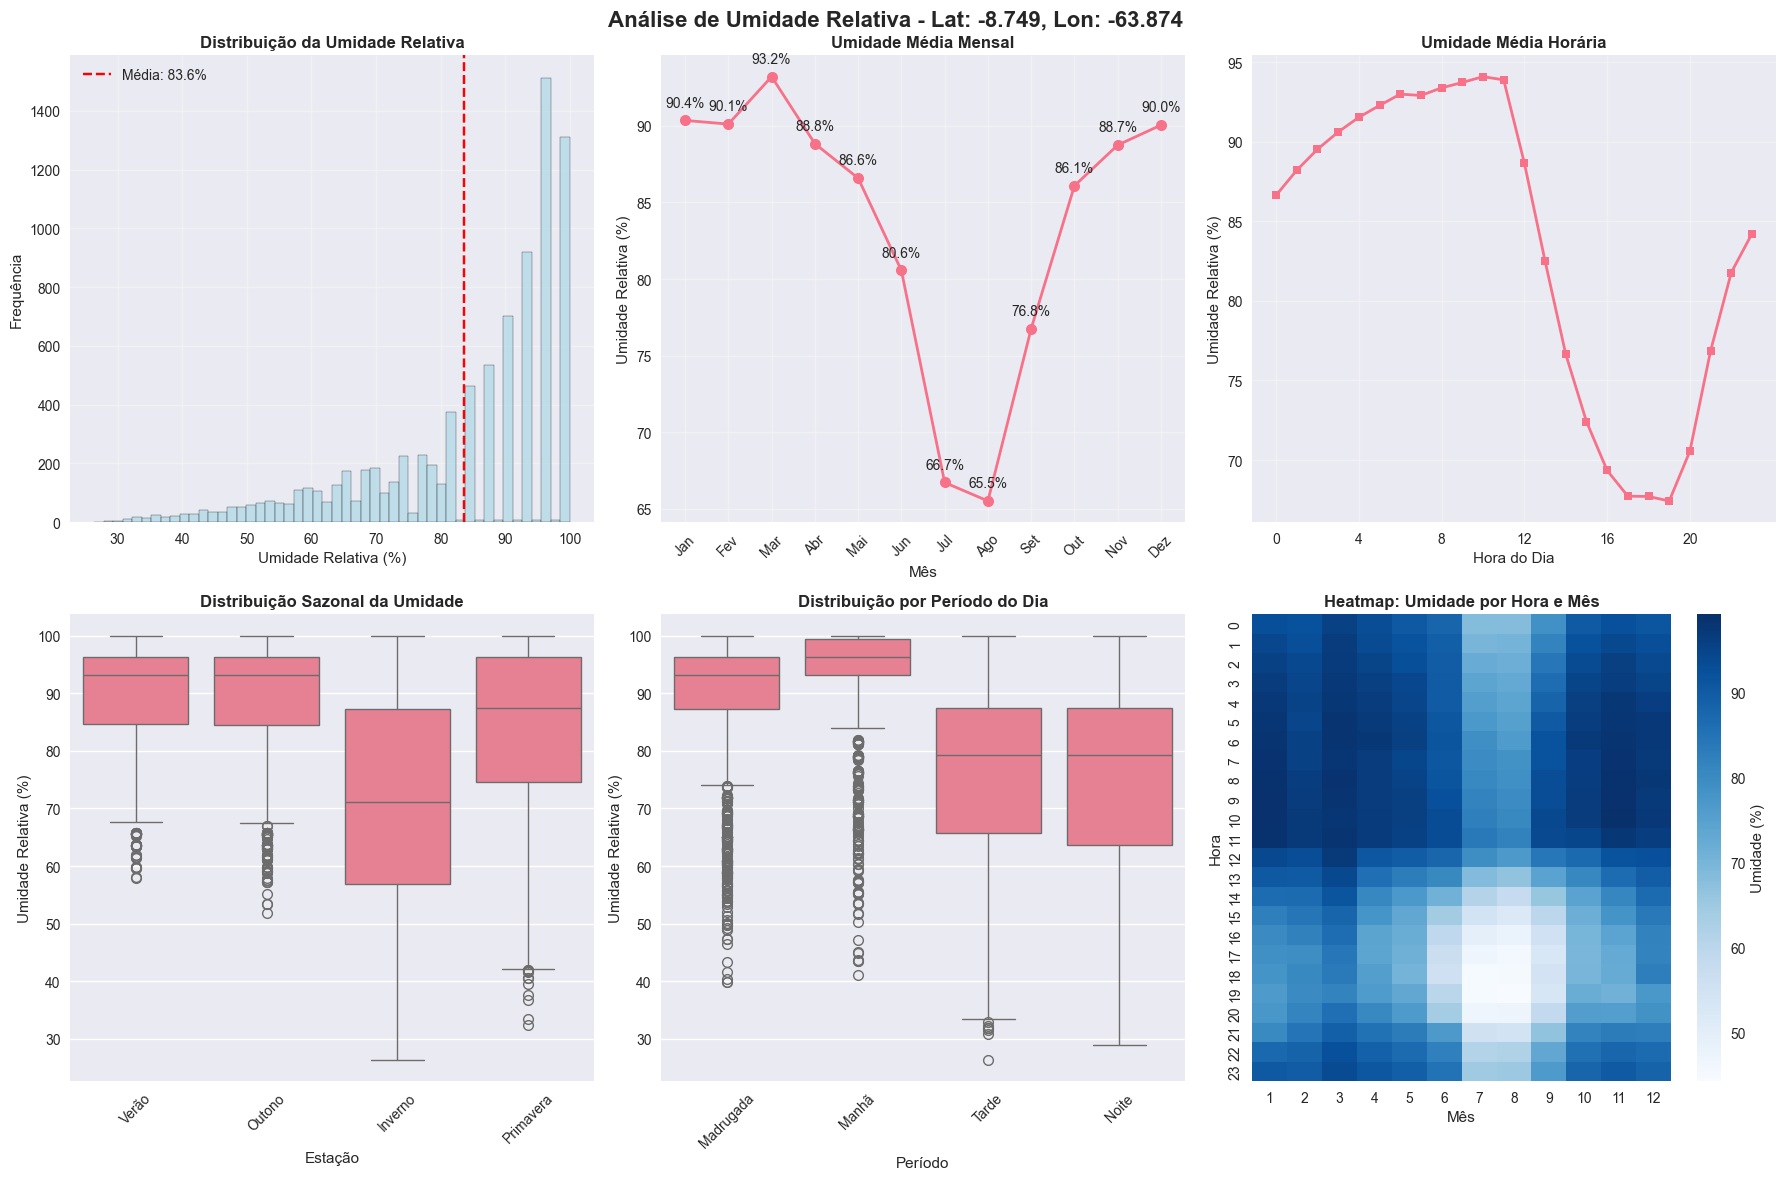

In [7]:
if success:
    print("📊 Gerando visualizações...")
    
    # Criar subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Análise de Umidade Relativa - Lat: {latitude:.3f}, Lon: {longitude:.3f}', 
                fontsize=16, fontweight='bold')
    
    # 1. Distribuição da umidade (histograma)
    ax1 = axes[0, 0]
    ax1.hist(df_humidity['RH'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    ax1.axvline(df_humidity['RH'].mean(), color='red', linestyle='--', 
               label=f'Média: {df_humidity["RH"].mean():.1f}%')
    ax1.set_title('Distribuição da Umidade Relativa', fontweight='bold')
    ax1.set_xlabel('Umidade Relativa (%)')
    ax1.set_ylabel('Frequência')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Variação mensal
    ax2 = axes[0, 1]
    monthly_means = df_humidity.groupby('month')['RH'].mean()
    meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
             'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
    ax2.plot(range(1, 13), monthly_means, marker='o', linewidth=2, markersize=8)
    ax2.set_title('Umidade Média Mensal', fontweight='bold')
    ax2.set_xlabel('Mês')
    ax2.set_ylabel('Umidade Relativa (%)')
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(meses, rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Adicionar valores nos pontos
    for i, val in enumerate(monthly_means, 1):
        ax2.annotate(f'{val:.1f}%', (i, val), textcoords="offset points", 
                    xytext=(0,10), ha='center')
    
    # 3. Variação horária
    ax3 = axes[0, 2]
    hourly_means = df_humidity.groupby('hour')['RH'].mean()
    ax3.plot(hourly_means.index, hourly_means.values, marker='s', linewidth=2, markersize=6)
    ax3.set_title('Umidade Média Horária', fontweight='bold')
    ax3.set_xlabel('Hora do Dia')
    ax3.set_ylabel('Umidade Relativa (%)')
    ax3.set_xticks(range(0, 24, 4))
    ax3.grid(True, alpha=0.3)
    
    # 4. Box plot sazonal
    ax4 = axes[1, 0]
    season_order = ['Verão', 'Outono', 'Inverno', 'Primavera']
    df_humidity_ordered = df_humidity.copy()
    df_humidity_ordered['season'] = pd.Categorical(df_humidity_ordered['season'], 
                                                  categories=season_order, ordered=True)
    sns.boxplot(data=df_humidity_ordered, x='season', y='RH', ax=ax4)
    ax4.set_title('Distribuição Sazonal da Umidade', fontweight='bold')
    ax4.set_xlabel('Estação')
    ax4.set_ylabel('Umidade Relativa (%)')
    ax4.tick_params(axis='x', rotation=45)
    
    # 5. Box plot por período do dia
    ax5 = axes[1, 1]
    period_order = ['Madrugada', 'Manhã', 'Tarde', 'Noite']
    df_humidity_ordered2 = df_humidity.copy()
    df_humidity_ordered2['period'] = pd.Categorical(df_humidity_ordered2['period'], 
                                                   categories=period_order, ordered=True)
    sns.boxplot(data=df_humidity_ordered2, x='period', y='RH', ax=ax5)
    ax5.set_title('Distribuição por Período do Dia', fontweight='bold')
    ax5.set_xlabel('Período')
    ax5.set_ylabel('Umidade Relativa (%)')
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Heatmap horário por mês
    ax6 = axes[1, 2]
    humidity_pivot = df_humidity.pivot_table(values='RH', index='hour', 
                                           columns='month', aggfunc='mean')
    sns.heatmap(humidity_pivot, cmap='Blues', ax=ax6, cbar_kws={'label': 'Umidade (%)'})
    ax6.set_title('Heatmap: Umidade por Hora e Mês', fontweight='bold')
    ax6.set_xlabel('Mês')
    ax6.set_ylabel('Hora')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ Gráficos não podem ser gerados devido a erro anterior.")

## 6. Análise Complementar

Análises adicionais sobre padrões de umidade e correlações.

In [8]:
if success:
    print("🔍 Realizando análises complementares...")
    
    # Correlação entre umidade e temperatura
    if 'T2m' in df_humidity.columns:
        correlation = df_humidity['RH'].corr(df_humidity['T2m'])
        print(f"\n🌡️ CORRELAÇÃO UMIDADE-TEMPERATURA:")
        print(f"   📊 Coeficiente de correlação: {correlation:.3f}")
        
        if abs(correlation) > 0.7:
            strength = "forte"
        elif abs(correlation) > 0.3:
            strength = "moderada"
        else:
            strength = "fraca"
        
        direction = "negativa" if correlation < 0 else "positiva"
        print(f"   📋 Correlação {strength} {direction}")
    
    # Classificação de umidade por faixas
    def classify_humidity(rh):
        if rh < 30:
            return 'Muito Baixa'
        elif rh < 50:
            return 'Baixa'
        elif rh < 70:
            return 'Moderada'
        elif rh < 85:
            return 'Alta'
        else:
            return 'Muito Alta'
    
    df_humidity['humidity_class'] = df_humidity['RH'].apply(classify_humidity)
    humidity_distribution = df_humidity['humidity_class'].value_counts(normalize=True) * 100
    
    print(f"\n📊 DISTRIBUIÇÃO POR FAIXAS DE UMIDADE:")
    for category in ['Muito Baixa', 'Baixa', 'Moderada', 'Alta', 'Muito Alta']:
        if category in humidity_distribution:
            print(f"   {category:>12}: {humidity_distribution[category]:5.1f}%")
    
    # Análise de extremos
    extreme_low = df_humidity['RH'] < 20  # Muito seco
    extreme_high = df_humidity['RH'] > 95  # Muito úmido
    
    print(f"\n⚡ ANÁLISE DE EXTREMOS:")
    print(f"   🔥 Horas com umidade < 20%: {extreme_low.sum()} ({extreme_low.mean()*100:.1f}%)")
    print(f"   💧 Horas com umidade > 95%: {extreme_high.sum()} ({extreme_high.mean()*100:.1f}%)")
    
    # Variabilidade por estação
    seasonal_variability = df_humidity.groupby('season')['RH'].std()
    print(f"\n🔄 VARIABILIDADE SAZONAL (desvio padrão):")
    for season in seasonal_variability.index:
        print(f"   {season:>10}: ±{seasonal_variability[season]:.2f}%")
    
    most_variable = seasonal_variability.idxmax()
    least_variable = seasonal_variability.idxmin()
    print(f"\n   📈 Estação mais variável: {most_variable}")
    print(f"   📉 Estação menos variável: {least_variable}")
    
else:
    print("⚠️ Análise complementar não executada devido a erro anterior.")

🔍 Realizando análises complementares...

🌡️ CORRELAÇÃO UMIDADE-TEMPERATURA:
   📊 Coeficiente de correlação: -0.736
   📋 Correlação forte negativa

📊 DISTRIBUIÇÃO POR FAIXAS DE UMIDADE:
    Muito Baixa:   0.1%
          Baixa:   4.5%
       Moderada:  16.0%
           Alta:  22.2%
     Muito Alta:  57.3%

⚡ ANÁLISE DE EXTREMOS:
   🔥 Horas com umidade < 20%: 0 (0.0%)
   💧 Horas com umidade > 95%: 2831 (32.3%)

🔄 VARIABILIDADE SAZONAL (desvio padrão):
      Inverno: ±18.31%
       Outono: ±10.23%
    Primavera: ±14.91%
        Verão: ±9.28%

   📈 Estação mais variável: Inverno
   📉 Estação menos variável: Verão


## 7. Salvar Resultados

Salva os dados e estatísticas para uso posterior.

In [ ]:
if success:
    print("💾 Salvando resultados...")
    
    # Criar nome dos arquivos baseado na localização
    location_name = f"lat_{latitude:.3f}_lon_{longitude:.3f}".replace('.', '_').replace('-', 'neg')
    
    try:
        # Salvar dados horários
        csv_filename = f"humidity_data_{location_name}.csv"
        df_humidity.to_csv(csv_filename, index=False)
        print(f"   📊 Dados horários salvos: {csv_filename}")
        
        # Salvar estatísticas
        stats_filename = f"humidity_stats_{location_name}.json"
        with open(stats_filename, 'w', encoding='utf-8') as f:
            json.dump(humidity_stats, f, indent=2, ensure_ascii=False)
        print(f"   📋 Estatísticas salvas: {stats_filename}")
        
        # Salvar dados brutos PVGIS
        raw_filename = f"pvgis_raw_{location_name}.json"
        with open(raw_filename, 'w', encoding='utf-8') as f:
            json.dump(tmy_data, f, indent=2, ensure_ascii=False)
        print(f"   🗂️ Dados brutos salvos: {raw_filename}")
        
        # Criar relatório resumido
        report_filename = f"humidity_report_{location_name}.txt"
        with open(report_filename, 'w', encoding='utf-8') as f:
            f.write(f"RELATÓRIO DE UMIDADE RELATIVA DO AR\n")
            f.write(f"="*50 + "\n\n")
            f.write(f"📍 Localização: {latitude:.6f}, {longitude:.6f}\n")
            f.write(f"📅 Data da análise: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            
            f.write(f"📊 RESULTADO PRINCIPAL:\n")
            f.write(f"   💧 Umidade média anual: {humidity_stats['geral']['media']:.2f}%\n\n")
            
            f.write(f"📈 ESTATÍSTICAS GERAIS:\n")
            for key, value in humidity_stats['geral'].items():
                f.write(f"   {key}: {value}%\n")
            
            f.write(f"\n🌤️ MÉDIAS SAZONAIS:\n")
            for season, stats in humidity_stats['sazonal'].items():
                f.write(f"   {season}: {stats['mean']:.1f}%\n")
            
            f.write(f"\n⏰ MÉDIAS POR PERÍODO:\n")
            for period, stats in humidity_stats['periodo_dia'].items():
                f.write(f"   {period}: {stats['mean']:.1f}%\n")
            
        print(f"   📄 Relatório salvo: {report_filename}")
        
    except Exception as e:
        print(f"   ❌ Erro ao salvar arquivos: {e}")
    
else:
    print("⚠️ Resultados não salvos devido a erro anterior.")

## 8. Resumo Final e Conclusões

Apresenta um resumo executivo da análise de umidade.

In [ ]:
if success:
    print("\n" + "="*70)
    print("🎯 RESUMO EXECUTIVO - ANÁLISE DE UMIDADE RELATIVA")
    print("="*70)
    
    media_umidade = humidity_stats['geral']['media']
    
    print(f"\n📍 LOCALIZAÇÃO ANALISADA:")
    print(f"   🌐 Coordenadas: {latitude:.6f}, {longitude:.6f}")
    print(f"   📊 Total de registros: {len(df_humidity):,}")
    print(f"   📅 Período coberto: {df_humidity['timestamp'].min().strftime('%Y-%m-%d')} a {df_humidity['timestamp'].max().strftime('%Y-%m-%d')}")
    
    print(f"\n💧 RESULTADO PRINCIPAL:")
    print(f"   🎯 UMIDADE RELATIVA MÉDIA ANUAL: {media_umidade:.2f}%")
    
    # Classificar o local por umidade
    if media_umidade < 30:
        classificacao = "MUITO SECO (Árido)"
        emoji = "🏜️"
    elif media_umidade < 50:
        classificacao = "SECO (Semi-árido)"
        emoji = "🌵"
    elif media_umidade < 70:
        classificacao = "MODERADO (Temperado)"
        emoji = "🌳"
    elif media_umidade < 85:
        classificacao = "ÚMIDO (Subtropical)"
        emoji = "🌿"
    else:
        classificacao = "MUITO ÚMIDO (Tropical)"
        emoji = "🌴"
    
    print(f"   {emoji} CLASSIFICAÇÃO: {classificacao}")
    
    print(f"\n📊 CARACTERÍSTICAS PRINCIPAIS:")
    print(f"   📈 Variação anual: {humidity_stats['geral']['minimo']:.1f}% - {humidity_stats['geral']['maximo']:.1f}%")
    print(f"   📊 Desvio padrão: ±{humidity_stats['geral']['desvio_padrao']:.1f}%")
    
    # Identificar padrões
    estacao_mais_umida = max(humidity_stats['sazonal'].items(), 
                            key=lambda x: x[1]['mean'])
    estacao_menos_umida = min(humidity_stats['sazonal'].items(), 
                             key=lambda x: x[1]['mean'])
    
    print(f"   🌤️ Estação mais úmida: {estacao_mais_umida[0]} ({estacao_mais_umida[1]['mean']:.1f}%)")
    print(f"   ☀️ Estação menos úmida: {estacao_menos_umida[0]} ({estacao_menos_umida[1]['mean']:.1f}%)")
    
    hora_mais_umida = humidity_stats['horario']['hora_mais_umida']
    hora_menos_umida = humidity_stats['horario']['hora_menos_umida']
    print(f"   🌅 Hora mais úmida: {hora_mais_umida:02d}:00 ({humidity_stats['horario']['umidade_maxima_horaria']:.1f}%)")
    print(f"   🌇 Hora menos úmida: {hora_menos_umida:02d}:00 ({humidity_stats['horario']['umidade_minima_horaria']:.1f}%)")
    
    print(f"\n✅ ANÁLISE CONCLUÍDA COM SUCESSO!")
    print(f"📁 Arquivos de resultados foram salvos no diretório atual.")
    
else:
    print("\n❌ ANÁLISE NÃO CONCLUÍDA")
    print("Verifique os erros anteriores e tente novamente.")
    print("\nPossíveis causas:")
    print("• Problema de conectividade com a internet")
    print("• Coordenadas inválidas")
    print("• Servidor PVGIS temporariamente indisponível")
    print("• Timeout na requisição (tente aumentar o valor)")

## 📝 Informações sobre o Notebook

### Objetivo:
Este notebook foi desenvolvido para obter dados de umidade relativa do ar através da API PVGIS TMY e calcular estatísticas descritivas para uma localização específica.

### Funcionalidades:
- ✅ Consulta automática à API PVGIS TMY
- ✅ Processamento de dados horários de umidade
- ✅ Cálculo de estatísticas descritivas completas
- ✅ Análise de padrões sazonais e diários
- ✅ Visualizações gráficas interativas
- ✅ Classificação climática por umidade
- ✅ Exportação de resultados em múltiplos formatos

### Dados Obtidos:
- **RH**: Umidade relativa do ar (%)
- **T2m**: Temperatura do ar a 2m (°C)
- **G(h)**: Irradiância global horizontal (W/m²)
- **WS10m**: Velocidade do vento a 10m (m/s)

### API Utilizada:
- **Fonte**: PVGIS (Photovoltaic Geographical Information System)
- **Versão**: v5.3
- **Endpoint**: `/tmy` (Typical Meteorological Year)
- **Dados**: Ano meteorológico típico baseado em anos de 2005-2020

### Limitações:
- Dados limitados às regiões cobertas pelo PVGIS
- Resolução temporal: horária
- Baseado em ano meteorológico típico (não dados em tempo real)
- Requer conexão com internet para acessar a API

### Como Usar:
1. Configure as coordenadas na **Seção 1**
2. Execute todas as células sequencialmente
3. Analise os resultados nas visualizações
4. Consulte os arquivos salvos para análises posteriores

---

**🔬 Desenvolvido para análise climatológica e estudos de umidade atmosférica baseados em dados PVGIS.**